In [21]:
import numpy as np
import IO
import SVD
from matplotlib import pyplot as plt
import time
import tools
import Wannier2Bloch

In [ ]:
alat = 7.676
#FCC SILICON
outdir = "./Plots_cb/"
DataDir = "../../DATA_cb/"
prefix = "lif"
at = (alat / 2.0) * np.array([[-1., 0., 1.], [0., 1., 1.], [-1., 1., 0.]]).T
k_mesh = [6,6,6]
G = np.array([0,0,0]) #gamma 
L = np.array([0.5,0.5,0.5])
X = np.array([0.5, 0.0, 0.5])
K = np.array([0.375, 0.3750, 0.75])
W = np.array([ 0.5000000000,0.2500000000,0.7500000000])
u = np.array([0.6250000000	, 0.2500000000	, 0.6250000000])
path1 = np.array([[G,X],[X,W],[W,K],[K,G],[G,L],[L,u],[u,W],[W,L],[L,K]])
xticks_labels1 = ['G','X','W','K','G','L','u','W','L','K']
path2 = np.array([[L,G],[G,K]])
xticks_labels2 = ['L','G','K']

### Import Hamiltonian and Dynamical Matrix
  - Generate R vectors
  - Sort Data structures

Reading Text Data: ../../../DATA_cb/epwdata.fmt
Dims: Bands=1, Modes=6, R_k=279, R_g=279, R_q=279
!All the file has been red!
Replicating wigner.f90 scan loops...

Total vectors found: 279 (Should be 279)


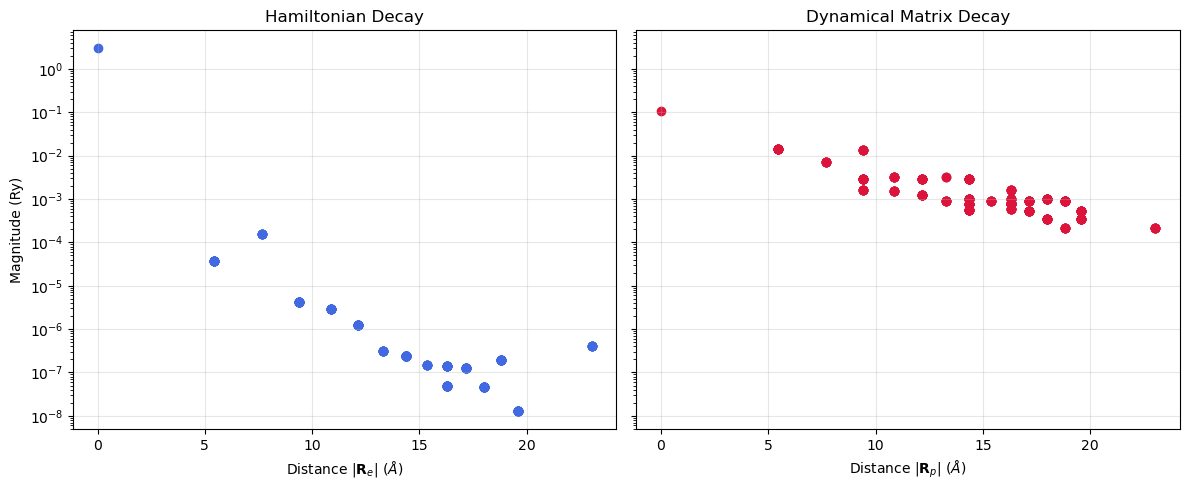

1


In [23]:
file_fmt = DataDir + "epwdata.fmt"
H_sort, D_sort,R_sort ,R, ef ,nbnd, nrr_k, nmodes, nrr_q, nrr_g = IO.read_epwdata_fmt(file_fmt, at,k_mesh,True,outdir)
print(nbnd)

### Import el-ph matrix in Coarse K mesh

In [24]:
file_epb = DataDir + prefix + ".epb1"
nq = 216
G_bloch,q_bloch = IO.read_epb_mixed_record(file_epb,nq,nbnd,nmodes)
if np.isnan(G).any() or np.isinf(G).any():
    print("CRITICAL WARNING: Your tensor contains NaN or Inf values!")
    # Optional: clean it
    G_bloch = np.nan_to_num(G)

print(G_bloch.shape)

Reading ../../../DATA_cb/lif.epb1...
  - Total Record Bytes: 112112860
  - nqc (q-points in file): 216
  - Reading epmatq (279936 complex elements)...
  ! Warning: 107502552 bytes remaining in record (padding?).
(216, 216, 6, 1, 1)


### Import el-ph matrix in Wannier space
    -plot Decay
    -Sort by distance
    - Match VASP shape

Reading ../../../DATA_cb/lif.epmatwp...
G shape loaded: (279, 279, 6, 1, 1)


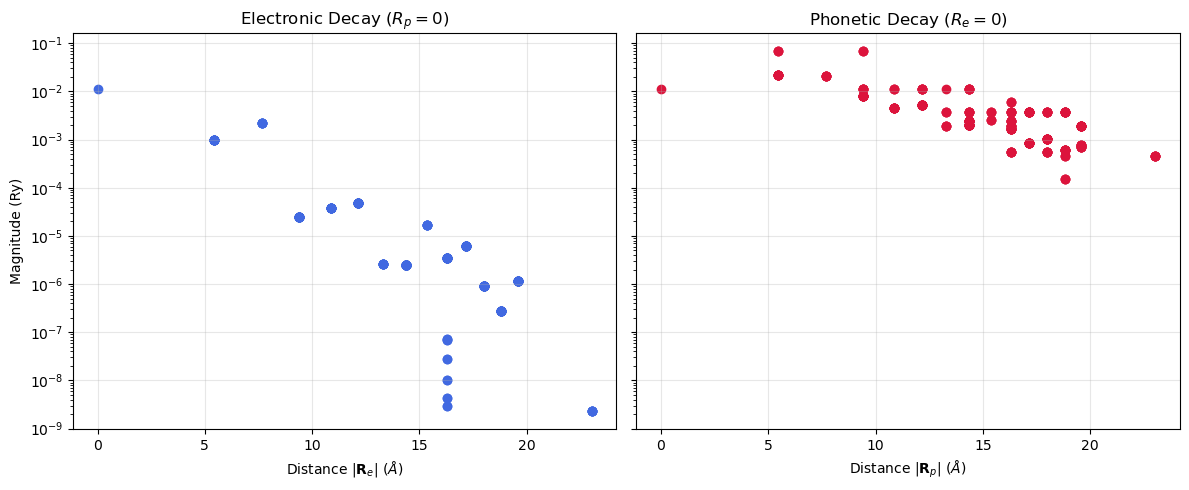

In [25]:
file_epmatwp = DataDir + prefix +  ".epmatwp"
G =  IO.read_epmatwp(file_epmatwp,nbnd, nrr_k, nmodes, nrr_g,R,PLOT=True,outdir = outdir)

### Obtain SVD decomposition

In [26]:
#Wannier
rel_error, x_percent = SVD.svd_trend(G,nbnd,nbnd,nmodes)
U,s,Vt = SVD.SVD(G,nbnd,nbnd,nmodes)

#Bloch
rel_error_k,x_perc_k = SVD.svd_trend(G_bloch,nbnd,nbnd,nmodes)
U_k,s_k,Vt_k = SVD.SVD(G_bloch,nbnd,nbnd,nmodes)

#err_tucker, x_tucker = SVD.tucker_trend(G, step=2)

Number of SVs: 279
Number of SVs: 216


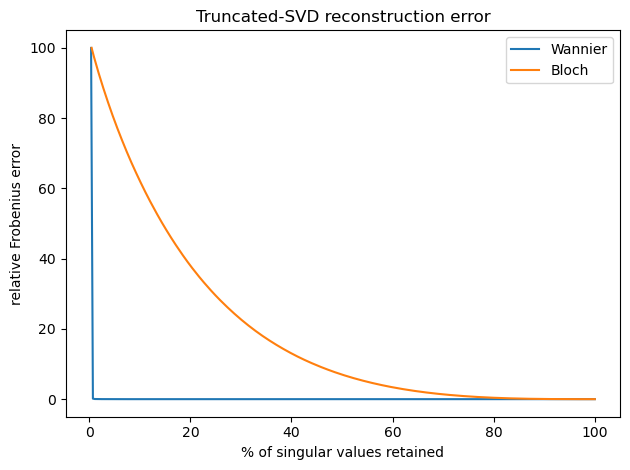

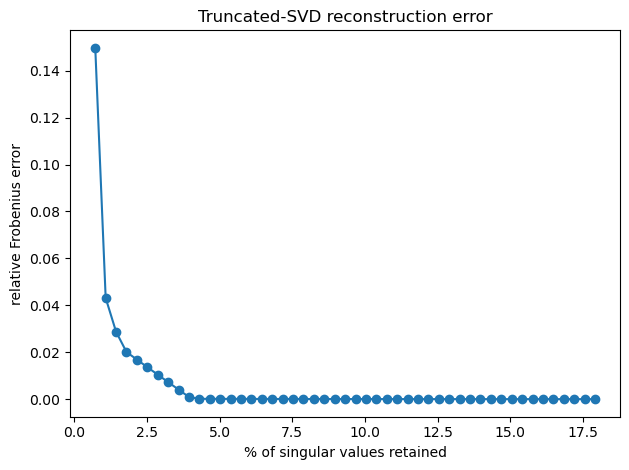

In [28]:

#Full Trend
fig = plt.figure()
plt.plot(x_percent[:], rel_error*100, label="Wannier")
plt.plot(x_perc_k, rel_error_k*100, label="Bloch")
#plt.plot(x_tucker,err_tucker*100,label="Tucker")
plt.xlabel("% of singular values retained")
plt.ylabel("relative Frobenius error")
plt.legend()
plt.title("Truncated-SVD reconstruction error")
plt.tight_layout()
plt.show()
fig.savefig(outdir+"SVD_trend.jpg")




#ZOOM
fig = plt.figure()
plt.plot(x_percent[1:50], rel_error[1:50]*100,"o-", label="unit-cell")
plt.xlabel("% of singular values retained")
plt.ylabel("relative Frobenius error")
plt.title("Truncated-SVD reconstruction error")
plt.tight_layout()
plt.show()
fig.savefig(outdir+"SVD_zoom.jpg")



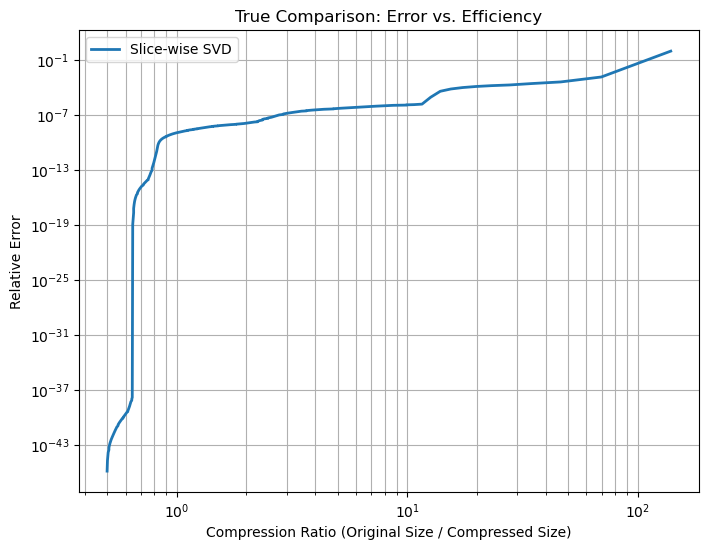

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def get_compression_ratios(ranks, method, tensor_shape):
    Nk, Nq, Nph, Nn, Nm = tensor_shape
    total_elements = np.prod(tensor_shape)
    ratios = []
    
    # Number of independent slices in your SVD approach
    num_slices = Nph * Nn * Nm
    
    for r in ranks:
        if method == 'svd':
            # U + S + V for every slice
            # U is (Nk * r), S is (r), V is (Nq * r)
            params_per_slice = (Nk * r) + r + (Nq * r)
            total_params = num_slices * params_per_slice
            
        elif method == 'tucker':
            # Assuming you kept bands/modes full (r_ph, r_n, r_m) 
            # and only compressed k, q to rank 'r'
            
            # 1. Core Tensor Size
            core_size = r * r * Nph * Nn * Nm
            
            # 2. Factor Matrices Size
            # Factors for k (Nk*r) and q (Nq*r)
            # Factors for ph, n, m are full size (Nph*Nph, etc)
            factors_size = (Nk * r) + (Nq * r) + (Nph**2) + (Nn**2) + (Nm**2)
            
            total_params = core_size + factors_size
            
        ratios.append(total_elements / total_params)
        
    return np.array(ratios)

# --- HOW TO USE WITH YOUR DATA ---

# 1. Define your shape
shape = (G.shape) # e.g. (279, 279, 3, 4, 4)

# 2. Convert your existing X-axis data
# 'x_perc_k' is your current percentage list (e.g., 1%, 2%...)
# Convert percentage back to integer rank first: r = (percent / 100) * 279
ranks_svd = (x_percent / 100.0 * shape[0]).astype(int)
#ranks_tucker = (x_tucker / 100.0 * shape[0]).astype(int)

# 3. Get the REAL X-axis (Compression Ratio)
ratio_svd = get_compression_ratios(ranks_svd, 'svd', shape)
#ratio_tucker = get_compression_ratios(ranks_tucker, 'tucker', shape)

# 4. Plot
plt.figure(figsize=(8,6))
plt.plot(ratio_svd, rel_error ,label='Slice-wise SVD', linewidth=2)
#plt.plot(ratio_tucker, err_tucker, label='Tucker', linewidth=2)

plt.xscale('log') # Log scale is essential here!
plt.yscale('log')
plt.xlabel('Compression Ratio (Original Size / Compressed Size)')
plt.ylabel('Relative Error')
plt.title('True Comparison: Error vs. Efficiency')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

LR factorization: 0.1175379753112793 seconds 
Relative error with 4% SV = 0.000162%
LR factorization: 0.04318523406982422 seconds 
Relative error with 4% SV = 82.6%


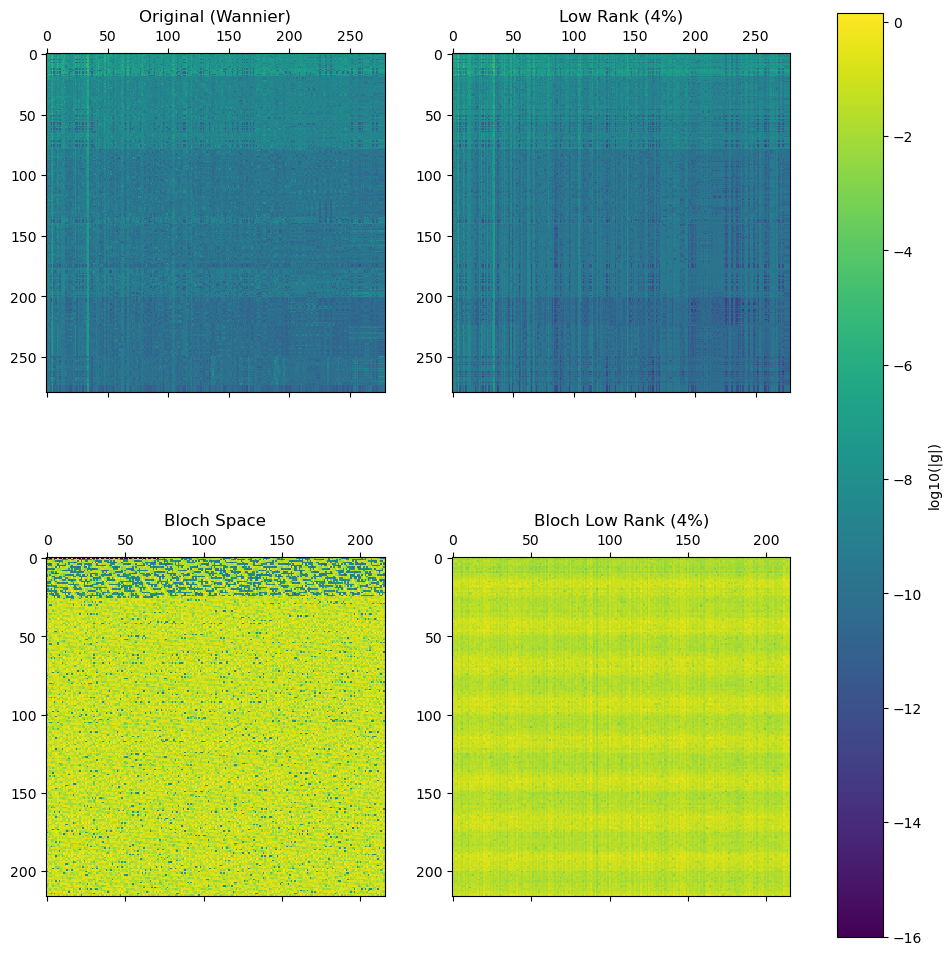

In [32]:
G_abs = np.abs(G)
perc = 4
rank = int(nrr_k * perc / 100)
rank_bloch = int(nq*perc/100)
# Calculate Low Rank Approximation
start_time = time.time()
G_LR2 = SVD.getLowRank(U, s, Vt, rank)
print("LR factorization: %s seconds " % (time.time() - start_time))


# Calculate Error
diff = np.abs(G_LR2 - G)**2
relative_error = np.sum(diff) / np.sum(G_abs**2)
print(f"Relative error with {perc}% SV = {relative_error*100:0.3}%")

start_time = time.time()
G_LR2_k = SVD.getLowRank(U_k, s_k, Vt_k, rank_bloch)
print("LR factorization: %s seconds " % (time.time() - start_time))


# Calculate Error
diff = np.abs(G_LR2_k - G_bloch)**2
relative_error = np.sum(diff) / np.sum(np.abs(G_bloch)**2)
print(f"Relative error with {perc}% SV = {relative_error*100:0.3}%")

# Pre-calculate the log10 data slices
#tiny epsilon (1e-16) prevents log(0) errors
slice_orig = np.log10(np.abs(G[..., 4, 0, 0]) + 1e-16)
slice_lr   = np.log10(np.abs(G_LR2[..., 4, 0, 0]) + 1e-16)
slice_bloch = np.log10(np.abs(G_bloch[..., 4, 0, 0]) + 1e-16)
slice_lr_bloch   = np.log10(np.abs(G_LR2_k[..., 4, 0, 0]) + 1e-16)

# Determine Global Min/Max for the Color Scale
global_min = min(slice_orig.min(), slice_lr.min(), slice_bloch.min(),slice_lr_bloch.min())
global_max = max(slice_orig.max(), slice_lr.max(), slice_bloch.max(),slice_lr_bloch.max())

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# Plot Original
im1 = axes[0][0].matshow(slice_orig, vmin=global_min, vmax=global_max)
axes[0][0].set_title("Original (Wannier)")
# Plot Low Rank
im2 = axes[0][1].matshow(slice_lr, vmin=global_min, vmax=global_max)
axes[0][1].set_title(f"Low Rank ({perc}%)")
# Plot Bloch
im3 = axes[1][0].matshow(slice_bloch, vmin=global_min, vmax=global_max)
axes[1][0].set_title("Bloch Space")
#Plot Bloch Low Rank
im4 = axes[1][1].matshow(slice_lr_bloch, vmin=global_min, vmax=global_max)
axes[1][1].set_title(f"Bloch Low Rank ({perc}%)")

# Add a single shared colorbar
fig.colorbar(im1, ax=axes.ravel().tolist(), label="log10(|g|)")

plt.show()
fig.savefig(outdir+"matrixPattern.jpg")

### Electron Band Interpolation

$H^{\mathrm{el}}_{mn}(\mathbf{k}')=\sum_{i,j}U_{m i}(\mathbf{k}')(\frac{1}{N_e}\sum_{\mathbf{R}_e} e^{i\mathbf{k}'\cdot\mathbf{R}_e})H_{ij}(\mathbf{R}_e)U^{\dagger}(\mathbf{k}')_{j n}$

#### Where by defintion we must have:
The new wannier matrices rotate the wannier WF to Bloch at new k point, and they must be ortghogonal
$  H^{\mathrm{el}}_{mn}(\mathbf{k}')= \delta_{mn}\epsilon _ n(\mathbf{k}')$




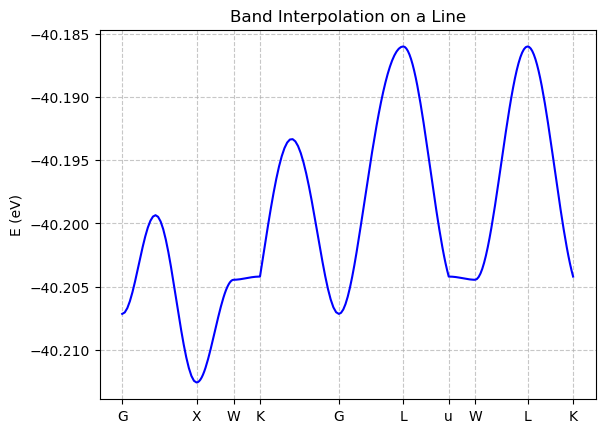

In [33]:
b_lat = tools.get_reciprocal_lattice(at)
q_cart1, x_axis1, xticks1 = tools.build_path_and_ticks(b_lat,path1,30)
q_cart2, x_axis2, xticks2 = tools.build_path_and_ticks(b_lat,path2,30)

E1,_ = Wannier2Bloch.interpolate_H(H_sort,q_cart1,R_sort)
Wannier2Bloch.plotBands(x_axis1,nbnd,E1,xticks1,xticks_labels1,outdir)


In [34]:
print(H_sort.shape)

(279, 1, 1)


### Phonon modes
$D^{\mathrm{ph}}_{\nu\mu}(\mathbf{q}')=\sum_{\alpha,\beta}[e^{\nu}_{\alpha}(\mathbf{q}')]^{*}(\frac{1}{N_p}\sum_{\mathbf{R}_p} e^{i\mathbf{q}'\cdot\mathbf{R}_p}D^{0p,\mathbf{R}_p}_{\alpha\beta})e^{\mu}_{\beta}(\mathbf{q}')$

$D^{\mathrm{ph}}_{\nu\mu}(\mathbf{q}') = \delta_{\nu\mu} \omega _{\nu}(\mathbf{q}')$

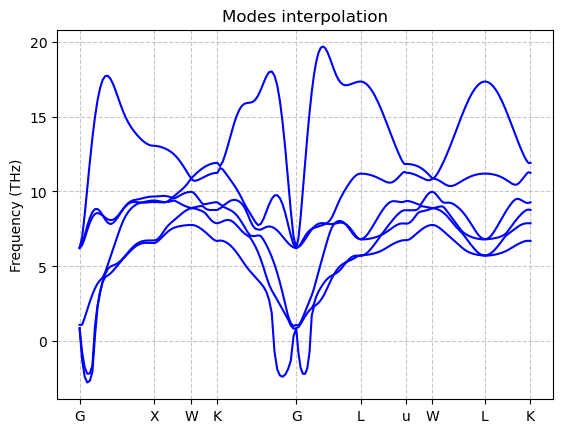

6


In [35]:
w1,_ = Wannier2Bloch.interpolate_D(D_sort,q_cart1,R_sort)
Wannier2Bloch.plotModes(x_axis1,nmodes,w1,xticks1,xticks_labels1,outdir)
print(nmodes)

### El-Ph matrix element interpolation

$g^{\nu}_{mn}(\mathbf{k'},\mathbf{q'})=\frac{1}{N_e}\sum_{k \alpha}\sum_{\mathbf{R}_e,\mathbf{R}_p}e^{i(\mathbf{k'}\cdot\mathbf{R}_e+\mathbf{q'}\cdot\mathbf{R}_p)}\,U_{m i}(\mathbf{k'}+\mathbf{q'})\;g^{\nu}_{i j k\alpha}(\mathbf{R}_e,\mathbf{R}_p)\;U^\dagger_{j n}(\mathbf{k'})\;e_{k\alpha}^{\nu}(\mathbf{q'})$

Where I can also use the Low Rank Factorization of g:

${g}_{i j k \alpha}^{rank}(\mathbf{R}_e, \mathbf{R}_p) = \sum_{\gamma=1}^{rank} s_{i j k \alpha}^{\gamma} u_{i j k \alpha}^{\gamma}(\mathbf{R}_e) v_{i j k \alpha}^{\gamma}(\mathbf{R}_p)$

In [36]:
# To simulate the condition in which I read from file all the SVD info I preelaborate
# the data for my benchmark
perc = 0.03
rank = int(s.shape[0]*perc)
print(f"Number of SV {rank} corresponding to {perc*100}%")
U_red = U[:,:rank]
Vt_red = Vt[:rank]
s_red = s[:rank]
start_time = time.time()
G_bloch,wq,Ek = Wannier2Bloch.Wannier2Bloch(H_sort,D_sort,G,U_red,Vt_red,s_red,R_sort,q_cart2,np.array([0,0,0]))
print("LowRank Wannierization: %s seconds " % (time.time() - start_time))

start_time = time.time()
G_bloch_full,wq_full,Ek_full = Wannier2Bloch.BENCHMARK(H_sort,D_sort,G,R_sort,q_cart2,np.array([0,0,0]))
print("FullRank Wannierization: %s seconds " % (time.time() - start_time))


Number of SV 8 corresponding to 3.0%
LowRank Wannierization: 0.04064297676086426 seconds 
FullRank Wannierization: 0.02962183952331543 seconds 


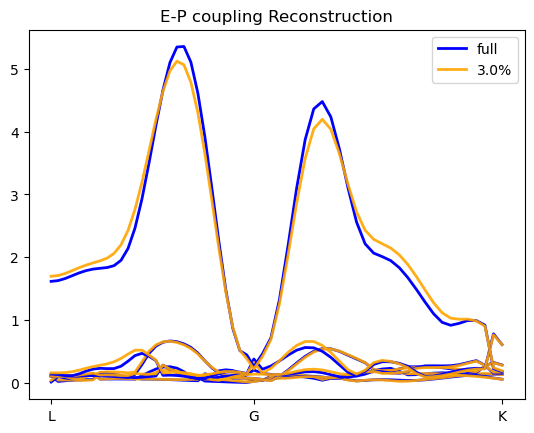

In [ ]:
tools.plot_EPC(
    G_bloch_full,G_bloch,
    wq_full,wq,
    nbnd,nmodes,
    x_axis2,xticks2,xticks_labels2,perc,outdir)

### Computational Complexity Considerations
The gain is only in the time to perform the  Fourier Transform from R to K space:

$ {g}_{i j k \alpha}(\mathbf{k'}, \mathbf{q'}) = \sum_{\mathbf{R}_p, \mathbf{R}_e} e^{i\mathbf{k'}\mathbf{R}_e + i\mathbf{q'}\mathbf{R}_p} {g}_{i j k \alpha}(\mathbf{R}_e, \mathbf{R}_p) \to O(N_{\mathbf{R}}^2) \\$

Instead one can do: 
$ \\ {g}_{i j k \alpha}^{rank}(\mathbf{k'}, \mathbf{q'}) = \sum_{\gamma=1}^{rank} s_{i j k \alpha}^{\gamma} u_{j k \alpha}^{\gamma}(\mathbf{k'}) v_{i j k \alpha}^{\gamma}(\mathbf{q'}) \to O(rank)\\ $

$u_{ i j k \alpha}^{\gamma}(\mathbf{k'}) = \sum_{\mathbf{R}_e} e^{i\mathbf{k'}\mathbf{R}_e} u_{i j k \alpha}^{\gamma}(\mathbf{R}_e)  $ 

$v_{i j k \alpha}^{\gamma}(\mathbf{q'}) = \sum_{\mathbf{R}_p} e^{i\mathbf{q'}\mathbf{R}_p} v_{i j k \alpha}^{\gamma}(\mathbf{R}_p) \to O(N_{\mathbf{R}}) \\$

Two times for each $\gamma$  $ \to O(rank \times N_{\mathbf{R}})\\$
$rank = 1,...,N_{\mathbf{R}} \\$

Plus the fixed overhead in both cases to interpolate ($O(N_{\mathbf{R}})$) and diagonalize $H$ and $D$, which is negligible being $O({N^3_{bands}})$ and  $O({N^3_{modes}})$ respectively.



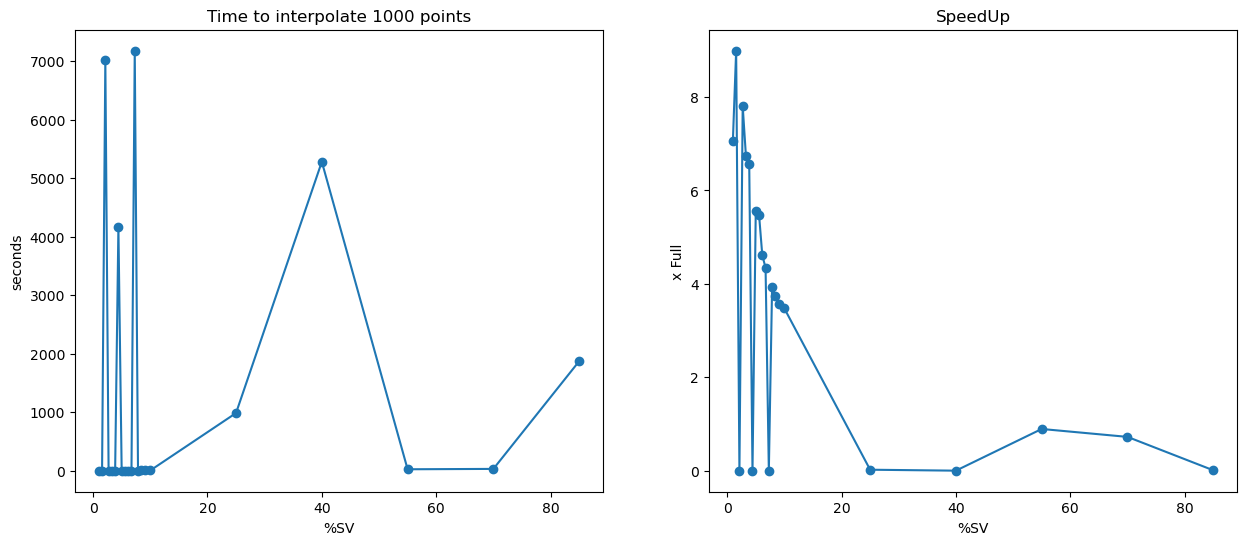

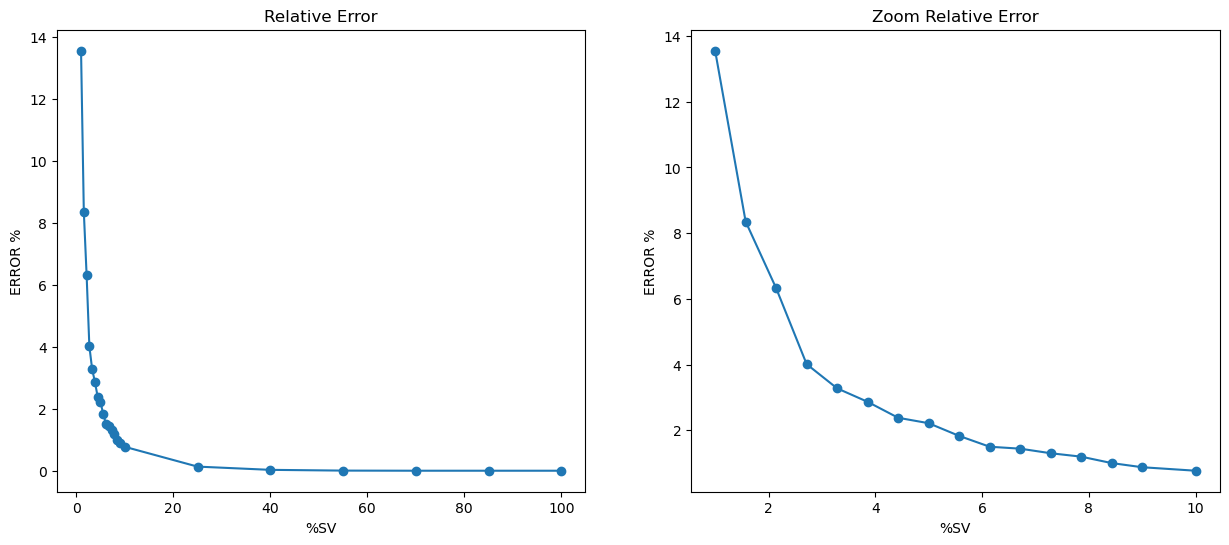

In [ ]:
N = int(1e3)
perc1, times1, errors1 = tools.performance_analysis(N,b_lat,H_sort,D_sort,G,R_sort,U,Vt,s,outdir)

(10000, 3)
full done
rank 2 done,shape: (1, 10000, 6, 3, 3)
rank 4 done,shape: (1, 10000, 6, 3, 3)
rank 5 done,shape: (1, 10000, 6, 3, 3)
rank 7 done,shape: (1, 10000, 6, 3, 3)
rank 9 done,shape: (1, 10000, 6, 3, 3)
rank 10 done,shape: (1, 10000, 6, 3, 3)
rank 12 done,shape: (1, 10000, 6, 3, 3)
rank 13 done,shape: (1, 10000, 6, 3, 3)
rank 15 done,shape: (1, 10000, 6, 3, 3)
rank 17 done,shape: (1, 10000, 6, 3, 3)
rank 18 done,shape: (1, 10000, 6, 3, 3)
rank 20 done,shape: (1, 10000, 6, 3, 3)
rank 21 done,shape: (1, 10000, 6, 3, 3)
rank 23 done,shape: (1, 10000, 6, 3, 3)
rank 25 done,shape: (1, 10000, 6, 3, 3)
rank 27 done,shape: (1, 10000, 6, 3, 3)
rank 69 done,shape: (1, 10000, 6, 3, 3)
rank 111 done,shape: (1, 10000, 6, 3, 3)
rank 153 done,shape: (1, 10000, 6, 3, 3)
rank 195 done,shape: (1, 10000, 6, 3, 3)
rank 237 done,shape: (1, 10000, 6, 3, 3)


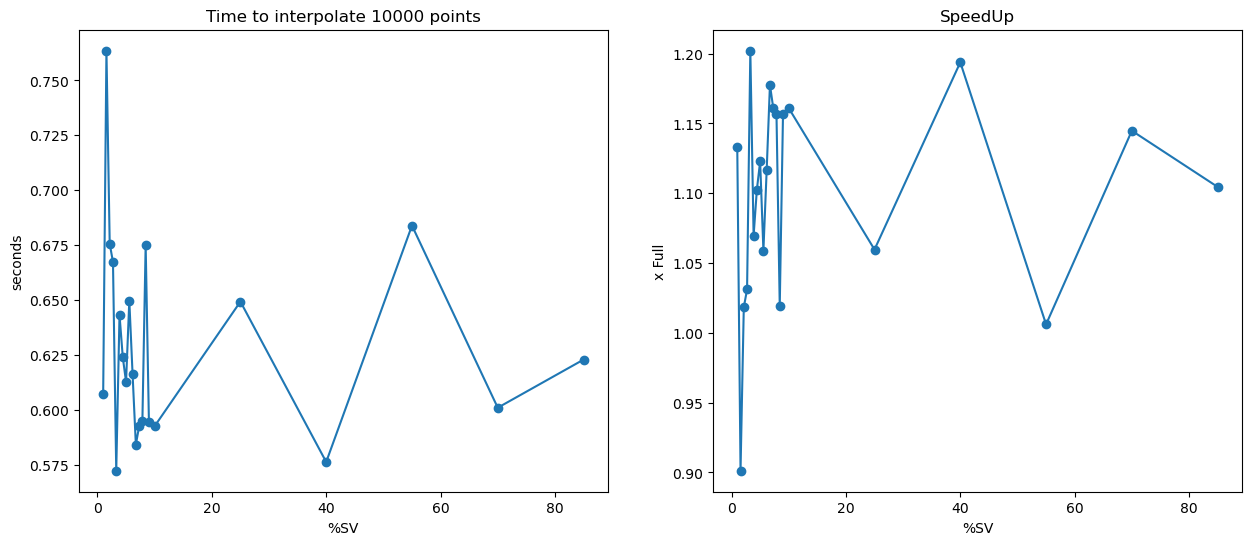

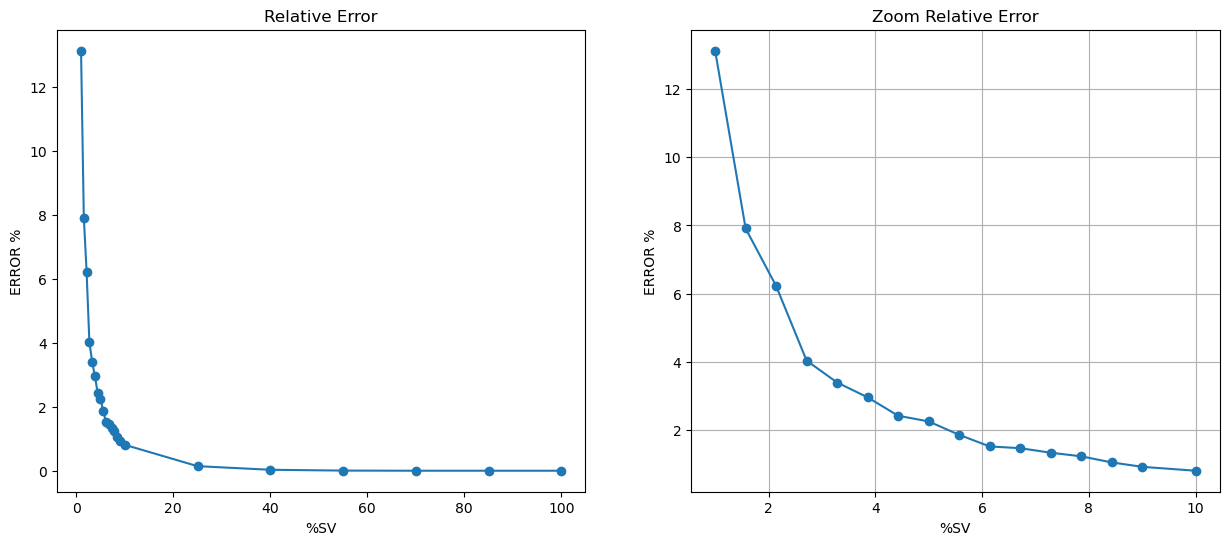

In [ ]:
N = int(1e4)
perc, times, errors = tools.performance_analysis_vectorized(N,b_lat,H_sort,D_sort,G,R_sort,U,Vt,s,outdir)

### TO DO:
- Try a more complex material (different atoms)
- Try with Disentanglement Bands
- C++ Interface to perform an Interpolation
- VASP or Manuel Engel Code